# Tutorial for Mixture of Expert (MoE) Forecasting Model

This notebook provides a minimal example on how to use the MoE forecasting model.

MoE runs in 2 settings:
1. Using external expert models
2. Using free parameters (no external experts)

Example codes are provided for both cases below.

In [1]:
# workaround to enable info-level logging in Jupyter notebook
%config Application.log_level='WORKAROUND'
%config Application.log_level='INFO'
import logging
logging.getLogger().setLevel(logging.INFO)

ERROR:root:The 'log_level' trait of an IPKernelApp instance expected any of [0, 10, 20, 30, 40, 50, 'DEBUG', 'INFO', 'WARN', 'ERROR', 'CRITICAL'], not the str 'WORKAROUND'.


## Load dataset

Note: change data dir below if inappropriate

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from ts_datasets.forecast import *

time_series, metadata = M4()[0]
print(time_series.shape)

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
100%|██████████| 414/414 [00:00<00:00, 610.42it/s]

(748, 1)


Now, we'll split the data into train & test splits. Visualize the 0th dim of the data.

train timeseries shape:  (700, 1)
test timeseries shape:  (48, 1)


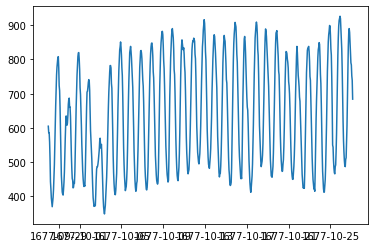

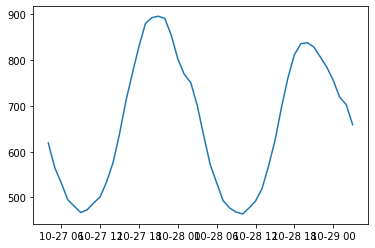

In [3]:
from merlion.utils import TimeSeries

train_data = TimeSeries.from_pd(time_series[metadata["trainval"]])
test_data  = TimeSeries.from_pd(time_series[~metadata["trainval"]])


print('train timeseries shape: ', train_data.to_pd().values.shape)
print('test timeseries shape: ', test_data.to_pd().values.shape)

column_names = list(train_data.to_pd().columns)
idx=0
tr = train_data.to_pd()[column_names[idx]]
plt.plot(tr)
plt.show()

te = test_data.to_pd()[column_names[idx]]
plt.plot(te)

## Create MoE model composed of external expert models and train

### Specify hyper-parameters

In [4]:
# save directory for ensemble state. Replace it with your own choice.
save_dir = 'models/moe'

###
nfree_experts=0 # <- no free parameters provided
lookback_len=20
max_forecast_steps=3
target_seq_index = 0
use_gpu=False
###


## Pytorch network hyper-params. These are the also the hyper-params that are used in case moe_model=None is passed to MoE_ForecasterEnsemble.
hidden_dim=256
dim_head = 2
mlp_dim=256
dim_dropout=0. # if data is multi-dimensionsal, this can be set to a non-zero value to allow model to handle missing dimensions during test time
time_step_dropout=0
## Pytorch network hyper-params

### Create expert models and MoE ensembler and train

In [5]:
from merlion.models.factory import ModelFactory
from merlion.models.ensemble.MoE_forecast import MoE_ForecasterEnsemble, MoE_ForecasterEnsembleConfig, TransformerModel
from merlion.models.ensemble.base import EnsembleTrainConfig
from merlion.transform.base import Identity
from merlion.transform.resample import TemporalResample


## Define configs for all the experts as well as the MoE ensembler
conf_sarima =  {
        "order": [15, 1, 5],
        "seasonal_order": [2, 0, 1, 24],
        "max_forecast_steps": max_forecast_steps,
        "target_seq_index":target_seq_index,
        "transform": Identity()
        }

config_arima = {
        "order": [15, 1, 5],
        "max_forecast_steps": max_forecast_steps,
        "target_seq_index": target_seq_index,
        "transform": Identity()
    }

config_vector_ar = {"max_forecast_steps": max_forecast_steps, "target_seq_index": target_seq_index, "maxlags": 14}

config_ensemble = MoE_ForecasterEnsembleConfig(batch_size=64, lr=0.0001,\
                                            nfree_experts=nfree_experts, epoch_max=100,\
                                            lookback_len=lookback_len,\
                                            max_forecast_steps=max_forecast_steps,\
                                            target_seq_index=target_seq_index,
                                            use_gpu=use_gpu,\
                                            transform=TemporalResample())

train_config_ensemble = EnsembleTrainConfig(valid_frac=0.5)

# Define expert models
model = ModelFactory.create("Sarima", **conf_sarima)
model2 = ModelFactory.create("Arima", **config_arima)
model3 = ModelFactory.create("VectorAR", **config_vector_ar)

models = [model, model2, model3]
nexperts = len(models)

'''
Instantiate deep network for MoE. It can also be instantiated as None. In that case, the default Pytorch network 
specified in the MoE_ForecasterEnsemble class will be used. FYI, the network below is used as the default network in 
MoE_ForecasterEnsemble.

'''
moe_model = TransformerModel(input_dim=train_data.dim, lookback_len=lookback_len, nexperts=nexperts,\
                    output_dim=max_forecast_steps, nfree_experts=nfree_experts,\
                    hid_dim=hidden_dim, dim_head = dim_head, mlp_dim=mlp_dim,\
                     pool='cls', dim_dropout=dim_dropout,\
                    time_step_dropout=time_step_dropout)
# moe_model = None # use me if you want to see the default model in use

# create MoE forecaster model
ensemble = MoE_ForecasterEnsemble(config=config_ensemble, models= models, moe_model=moe_model)

# train & save MoE
loss_list = ensemble.train(train_data=train_data, train_config = train_config_ensemble)
ensemble.save(save_dir)

INFO:merlion.models.ensemble.MoE_forecast:Training model 1/3...
INFO:merlion.models.ensemble.MoE_forecast:Training model 2/3...
INFO:merlion.models.ensemble.MoE_forecast:Training model 3/3...
INFO:merlion.models.ensemble.MoE_forecast:Extracting and storing expert predictions
  0%|          | 0/6 [00:00<?, ?it/s]INFO:merlion.models.ensemble.MoE_forecast:Getting model 1/3 predictions...
INFO:merlion.models.ensemble.MoE_forecast:Getting model 2/3 predictions...
INFO:merlion.models.ensemble.MoE_forecast:Getting model 3/3 predictions...
 17%|█▋        | 1/6 [00:06<00:33,  6.78s/it]INFO:merlion.models.ensemble.MoE_forecast:Getting model 1/3 predictions...
INFO:merlion.models.ensemble.MoE_forecast:Getting model 2/3 predictions...
INFO:merlion.models.ensemble.MoE_forecast:Getting model 3/3 predictions...
 33%|███▎      | 2/6 [00:10<00:19,  4.91s/it]INFO:merlion.models.ensemble.MoE_forecast:Getting model 1/3 predictions...
INFO:merlion.models.ensemble.MoE_forecast:Getting model 2/3 predictions.

Epoch 100 Loss: 0.912859: 100%|██████████| 6/6 [00:03<00:00,  1.72it/s]


### Load the saved ensemble model

In [6]:
ensemble_loaded = MoE_ForecasterEnsemble.load(save_dir)

### Forecast using the loaded model

In [7]:
lookback_len=20
forecast_len=3

sample_length = lookback_len + forecast_len

target_seq_index=0
start_idx = 0
end_idx = sample_length

timestamps = test_data.univariates[test_data.names[0]].time_stamps[start_idx: end_idx]
data = test_data.to_pd().values
data = data[start_idx: end_idx]

timestamps = timestamps[lookback_len:]
x = data[:lookback_len]
x_ts = test_data[start_idx: start_idx+ lookback_len]
y = data[lookback_len:, target_seq_index]

print('True output:\n')
print(y)

# perform single forecast
print('Performing single forecast:\n')
forecast, se = ensemble_loaded.forecast(time_stamps=timestamps,
                 time_series_prev=x_ts, expert_idx=None, mode='max', use_gpu=False)

print('Forecast\n', forecast)
print('Standard Error\n', se)

# perform batch forecast (for simplicity, just feeding a list of single sample)
print('\n\nPerforming batch forecast (notice the output is a list):\n')
forecast, se = ensemble_loaded.batch_forecast(time_stamps_list=[timestamps],
                 time_series_prev_list = [x_ts], expert_idx=None, mode='max', use_gpu=False)

print('Forecasts\n', forecast)
print('Standard Errors\n', se)

True output:

[803. 769. 751.]
Performing single forecast:

Forecast
                              H1
1677-10-28 00:00:00  810.339722
1677-10-28 01:00:00  796.296448
1677-10-28 02:00:00  760.550842
Standard Error
                          H1_err
1677-10-28 00:00:00   42.765224
1677-10-28 01:00:00  198.829971
1677-10-28 02:00:00  350.278381


Performing batch forecast (notice the output is a list):

Forecasts
 [                           H1_0
1677-10-28 00:00:00  810.339722
1677-10-28 01:00:00  796.296448
1677-10-28 02:00:00  760.550842]
Standard Errors
 [                       H1_err_0
1677-10-28 00:00:00   42.765224
1677-10-28 01:00:00  198.829971
1677-10-28 02:00:00  350.278381]


### Retrieve forecasts of individual experts along with their confidence from the loaded model

In [8]:
# perform forecast at the beginning of the test_data timestamp of length 3 and lookback=20
lookback_len=20
forecast_len=3

sample_length = lookback_len + forecast_len

target_seq_index=0
start_idx = 0
end_idx = sample_length

timestamps = test_data.univariates[test_data.names[0]].time_stamps[start_idx: end_idx]
data = test_data.to_pd().values
data = data[start_idx: end_idx]

timestamps = timestamps[lookback_len:]
x = data[:lookback_len] # shape (20,1)
x_ts = test_data[start_idx: start_idx+ lookback_len]
y = data[lookback_len:, target_seq_index]

print('True output:\n')
print(y)

# perform single forecast
print('Getting individual expert forecast and standard deviation for single data (notice the array shape):\n')
forecast, std = ensemble_loaded._forecast(time_stamps=timestamps,
                 time_series_prev=x_ts, expert_idx=None, use_gpu=False)

print(f'Forecast (shape: {forecast.shape})\n', forecast)
print(f'Standard deviation (shape: {std.shape})\n', std)

# perform batch forecast (for simplicity, just feeding a list of single sample)
print('\n\nGetting individual expert forecast and standard deviation for a batch of data (notice the array shape):\n')
forecast, std = ensemble_loaded._batch_forecast(time_stamps_list=[timestamps],
                 time_series_prev_array=np.expand_dims(x, axis=0), # shape (1,20,1)
                 time_series_prev_list = [x_ts], expert_idx=None, use_gpu=False)

print(f'Forecast (shape: {forecast.shape})\n', forecast)
print(f'Standard deviation (shape: {std.shape})\n', std)

True output:

[803. 769. 751.]
Getting individual expert forecast and standard deviation for single data (notice the array shape):

Forecast (shape: (3, 3))
 [[828.93043244 796.29646378 760.5508621 ]
 [812.10700752 760.22152836 709.16665671]
 [810.33973458 757.56872591 700.9503937 ]]
Standard deviation (shape: (3, 3))
 [[0.361902   0.47081903 0.7306497 ]
 [0.26711744 0.3186435  0.14048512]
 [0.3709806  0.21053748 0.12886517]]


Getting individual expert forecast and standard deviation for a batch of data (notice the array shape):

Forecast (shape: (1, 3, 3))
 [[[828.93043244 796.29646378 760.5508621 ]
  [812.10700752 760.22152836 709.16665671]
  [810.33973458 757.56872591 700.9503937 ]]]
Standard deviation (shape: (1, 3, 3))
 [[[0.361902   0.47081903 0.7306497 ]
  [0.26711744 0.3186435  0.14048512]
  [0.3709806  0.21053748 0.12886517]]]


### Evaluate MoE

The code below shows how to evaluate MoE.

  0%|          | 0/1 [00:00<?, ?it/s]

sMAPE_conf: 2.184 sMAPE_not_conf: 0.000 recall: 100.000% | Plain sMAPE 2.184:   0%|          | 0/1 [00:01<?, ?it/s]
sMAPE_conf: 2.184 sMAPE_not_conf: 0.000 recall: 100.000% | Plain sMAPE 2.184: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


torch.Size([25, 3])


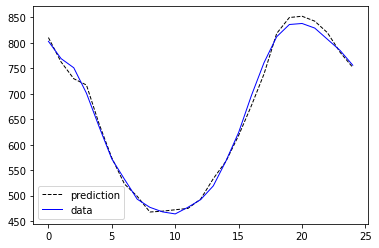

sMAPE on confident samples: 2.18
sMAPE on not confident samples: 0.00
Percentage of samples on which MoE was confident: 100.00%  (use a different confidence_thres to change this)
sMAPE on all samples: 2.18


In [9]:


expert_idx=None
# if expert_idx=None, MoE uses all the experts provided and uses the 'mode' strategy specified below to forecast
# if value is int (E.g. 0), MoE only uses the external expert at the corresponding index of `models` to make forecasts
mode='max' # either mean or max. Max picks the expert with the highest confidence; mean computes the weighted average.
use_gpu=False # set True if GPU available for faster speed
use_batch_forecast=True # set True for higher speed

y_pred_list, std_list, y_list, sMAPE_conf, sMAPE_not_conf, recall, overall_sMAPE =\
                ensemble_loaded.evaluate(test_data, mode=mode, expert_idx=expert_idx,\
                                         use_gpu=use_gpu, use_batch_forecast=use_batch_forecast, confidence_thres=100)

out_idx=0 # plot this idx of all the steps forecasted by MoE
print(y_pred_list.shape)
plt.plot(y_pred_list[:100, out_idx], '--', color='k', label='prediction', linewidth=1) # plotting 1st 100 for clarity
plt.plot(y_list[:100, out_idx], color='b', label='data', linewidth=1)
# plt.fill_between(range(y_pred_list[:100, out_idx].shape[0]), y_pred_list[:100, out_idx]-std_list[:100, out_idx],\
#                  y_pred_list[:100, out_idx]+std_list[:100, out_idx]) # standard deviation error band 
plt.legend()
plt.show()

print(f'sMAPE on confident samples: {sMAPE_conf:.2f}')
print(f'sMAPE on not confident samples: {sMAPE_not_conf:.2f}')
print(f'Percentage of samples on which MoE was confident: {recall:.2f}%  (use a different confidence_thres to change this)')
print(f'sMAPE on all samples: {overall_sMAPE:.2f}')


## Create MoE model containing free parameters (no external experts) and train

### Specify hyper-parameters

In [10]:
import os
# save directory for ensemble state. Replace it with your own choice.
save_dir = 'models/moe2'

###
nfree_experts= 3000 # <- number of free experts
lookback_len=20
max_forecast_steps=3
target_seq_index = 0
use_gpu=False
###


## Pytorch network hyper-params. These are the also the hyper-params that are used in case moe_model=None is passed to MoE_ForecasterEnsemble.
hidden_dim=256
dim_head = 2
mlp_dim=256
dim_dropout=0. # if data is multi-dimensionsal, this can be set to a non-zero value to allow model to handle missing dimensions during test time
time_step_dropout=0
## Pytorch network hyper-params


### Create MoE ensembler and train

In [11]:
config_ensemble = MoE_ForecasterEnsembleConfig(
    batch_size=64, lr=0.0001, nfree_experts=nfree_experts, epoch_max=300,
    lookback_len=lookback_len, max_forecast_steps=max_forecast_steps,
    target_seq_index=target_seq_index, use_gpu=use_gpu,
    transform=TemporalResample())

train_config_ensemble = EnsembleTrainConfig(valid_frac=0.5)

# Define expert models
models = [] # <- no external experts provided
nexperts = len(models)

# instantiate deep network for MoE
moe_model = TransformerModel(input_dim=len(train_data.names), lookback_len=lookback_len, nexperts=nexperts,\
                    output_dim=max_forecast_steps, nfree_experts=nfree_experts,\
                    hid_dim=hidden_dim, dim_head = dim_head, mlp_dim=mlp_dim,\
                     pool='cls', dim_dropout=dim_dropout,\
                    time_step_dropout=time_step_dropout)
moe_model = None # use me if you want to see the default model in use

# create MoE forecaster model
ensemble = MoE_ForecasterEnsemble(config=config_ensemble, models= models, moe_model=moe_model)

# train MoE
loss_list = ensemble.train(train_data=train_data, train_config = train_config_ensemble)

ensemble.save(save_dir)

Epoch 112 Loss: 3.303129: 100%|██████████| 11/11 [00:03<00:00,  3.32it/s]


Epoch 222 Loss: 1.322314: 100%|██████████| 11/11 [00:03<00:00,  3.54it/s]


Epoch 300 Loss: 0.570626: 100%|██████████| 11/11 [00:03<00:00,  3.02it/s]


### Evaluate MoE

The code below shows how to evaluate MoE.

In [12]:
ensemble_loaded = MoE_ForecasterEnsemble.load(save_dir)

### Load the saved ensemble model

  0%|          | 0/1 [00:00<?, ?it/s]

sMAPE_conf: 1.872 sMAPE_not_conf: 2.411 recall: 21.333% | Plain sMAPE 2.296: 100%|██████████| 1/1 [00:00<00:00, 37.30it/s]


torch.Size([25, 3])


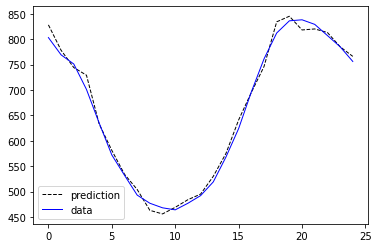

sMAPE on confident samples: 1.87
sMAPE on not confident samples: 2.41
Percentage of samples on which MoE was confident: 21.33% (use a different confidence_thres to change this)
sMAPE on all samples: 2.30


In [13]:


expert_idx=None
# when no external experts are used, the value of expert_idx is not used in the 
# forecast/batch_forecast/evaluate functions
mode='max' # either mean or max. Max picks the expert with the highest confidence; mean computes the weighted average.
use_gpu=False # set True if GPU available for faster speed
use_batch_forecast=True # set True for higher speed

y_pred_list, std_list, y_list, sMAPE_conf, sMAPE_not_conf, recall, overall_sMAPE =\
                    ensemble_loaded.evaluate(test_data, mode=mode, expert_idx=expert_idx,\
                                         use_gpu=use_gpu, use_batch_forecast=use_batch_forecast, confidence_thres=1.)

out_idx=0 # plot this idx of all the steps forecasted by MoE
print(y_pred_list.shape)
plt.plot(y_pred_list[:100, out_idx], '--', color='k', label='prediction', linewidth=1)
plt.plot(y_list[:100, out_idx], color='b', label='data', linewidth=1)
# plt.fill_between(range(y_pred_list[:100, out_idx].shape[0]), y_pred_list[:100, out_idx]-std_list[:100, out_idx],\
#                  y_pred_list[:100, out_idx]+std_list[:100, out_idx]) # standard deviation error band 
plt.legend()
plt.show()

print(f'sMAPE on confident samples: {sMAPE_conf:.2f}')
print(f'sMAPE on not confident samples: {sMAPE_not_conf:.2f}')
print(f'Percentage of samples on which MoE was confident: {recall:.2f}% (use a different confidence_thres to change this)')
print(f'sMAPE on all samples: {overall_sMAPE:.2f}')
